# DB-Scan

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

We perform the clustering on ```cylists.csv``` dataset using DB-Scan algorithm.

In [2]:
# Load the dataset
cyclists_df = pd.read_csv('../dataset/cyclists_outlier.csv')

In [3]:
# Specify the columns to keep
columns_to_keep = ["avg_relative_position", "mean_sq", "career_level"]

# drop the unnecessary columns for the clustering and keep only the numerical columns
numerical_cyclists_df = cyclists_df[columns_to_keep]
numerical_cyclists_df.head()

,avg_relative_position,mean_sq,career_level
0,4.725525,1615.878378,14371.866873
1,10.415002,775.122449,1514.222579
2,7.259367,1052.086957,8115.442081
3,9.004356,784.895833,1673.263534
4,8.623247,972.963542,11460.308567


We normalize the features

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(numerical_cyclists_df)
x_scaled.shape

(3476, 3)

Briefly check that values are in the range [0,1]

In [5]:
for i, column in enumerate(columns_to_keep):
    print(f"{column}: min = {x_scaled[:, i].min()}, max = {x_scaled[:, i].max()}")

avg_relative_position: min = 0.0, max = 1.0
mean_sq: min = 0.0, max = 1.0
career_level: min = 0.0, max = 1.0


Plot to try to "visualize" somehow data distribution

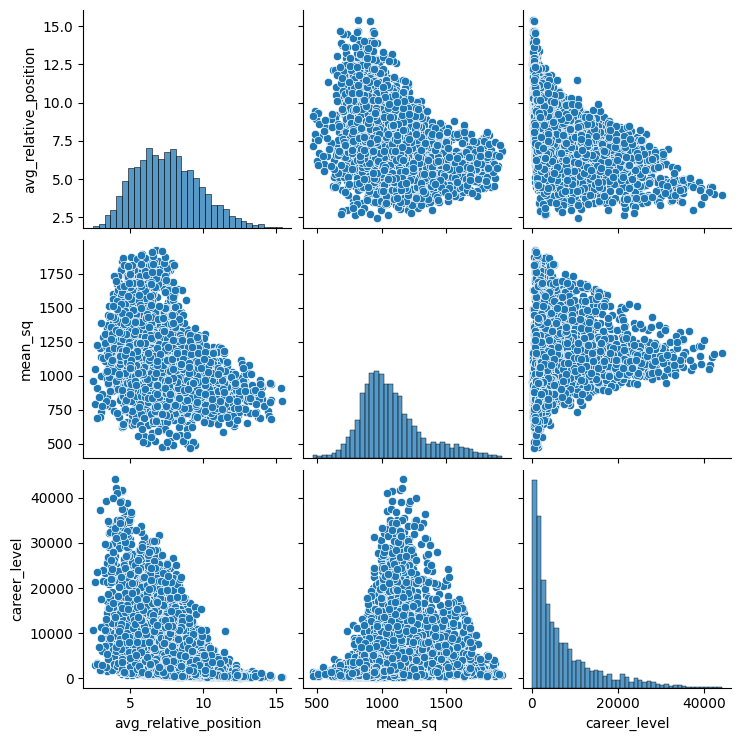

In [6]:
import seaborn as sns

# pairplot the numerical columns
sns.pairplot(numerical_cyclists_df)
plt.show()

Calculate the nearest neighbors distance for each point in the dist

In [7]:
dist = pdist(x_scaled, 'euclidean') # pair-wise distances
dist = squareform(dist) # distance matrix

In [8]:
k = 5 # number of nearest neighbors
kth_distances = list() # list of distances to the kth nearest neighbor
# iterate over the distances to find the kth nearest neighbor for each data point
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

Using the elbow method, we find the optimal value for eps

The elbow value is at index: 3433


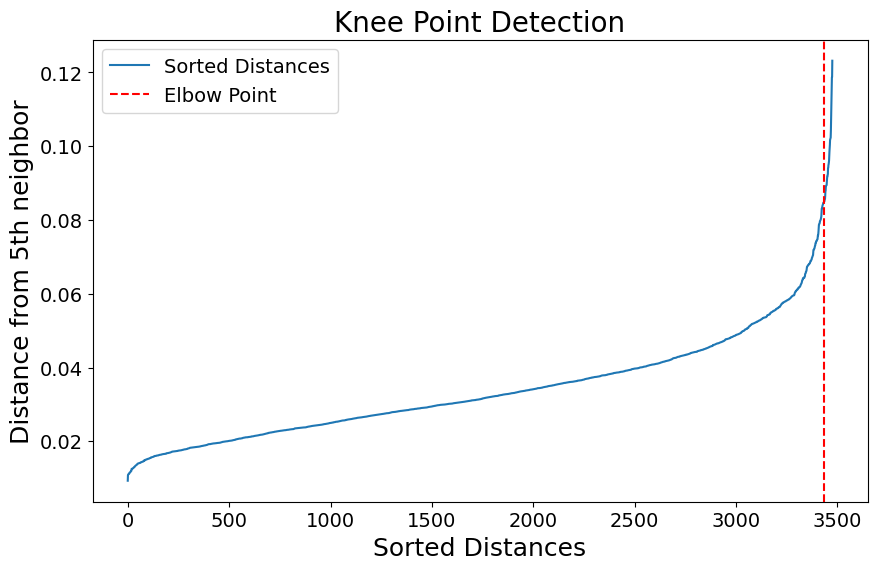

In [9]:
sorted_distances = np.sort(kth_distances)
kneedle = KneeLocator(
    np.arange(1, len(sorted_distances) + 1),
    sorted_distances,
    curve='convex',
    direction='increasing'
)

# Extract elbow value
elbow_value = kneedle.elbow
print(f'The elbow value is at index: {elbow_value}')

# Plot kth distances with the elbow point
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_distances)), sorted_distances, label="Sorted Distances")
plt.axvline(x=elbow_value - 1, color='r', linestyle='--', label="Elbow Point")
plt.ylabel(f'Distance from {k}th neighbor', fontsize=18)
plt.xlabel('Sorted Distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Knee Point Detection', fontsize=20)
plt.legend(fontsize=14)
plt.show()

Performing the clustering using DB-Scan algorithm

In [10]:
min_samples = [5, 7, 10, 12, 15, 20, 25, 30, 50, 80]
epsilon_candidates = np.linspace(0.01, 1, 200) # create a candidates around the elbow value (~0.08)

In [11]:
results = []
for eps in epsilon_candidates:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(x_scaled)
        n_clusters = len(np.unique(dbscan.labels_))
        if n_clusters == 1:
            silhouette = -1
            DBscore = max

        else:
            silhouette = silhouette_score(x_scaled, dbscan.labels_)
            DBscore = davies_bouldin_score(x_scaled, dbscan.labels_)
        results.append({'eps': eps, 'min_samples': min_sample, 'n_clusters': n_clusters, 'silhouette': silhouette, 'DBscore': DBscore})
        

### Best Result

Here is reported the best result obtained with DBSCAN algorithm basing only on silhouette score.

In [12]:
results_df = pd.DataFrame(results).sort_values(by=['silhouette'], ascending=False)
results_df.head(10)

,eps,min_samples,n_clusters,silhouette,DBscore
328,0.169196,50,2,0.561595,0.293412
308,0.159246,50,2,0.561595,0.293412
213,0.114472,12,2,0.561595,0.293412
399,0.204020,80,2,0.561595,0.293412
389,0.199045,80,2,0.561595,0.293412
379,0.194070,80,2,0.561595,0.293412
267,0.139347,30,2,0.561595,0.293412
348,0.179146,50,2,0.561595,0.293412
246,0.129397,25,2,0.561595,0.293412
318,0.164221,50,2,0.561595,0.293412


Refit the model with the best parameters

In [13]:
from sklearn.decomposition import PCA

eps = results_df.iloc[0]['eps']
min_samples = int(results_df.iloc[0]['min_samples'])

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(x_scaled)

DBSCAN(eps=np.float64(0.1691959798994975), min_samples=50)

Now we check the number of clusters found

In [14]:
unique_labels, counts = np.unique(dbscan.labels_, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
for label, count in cluster_counts.items():
    print(f"Cluster {label}: {count} samples")

Cluster -1: 1 samples
Cluster 0: 3475 samples


Avoiding the outliers, the number of clusters is 1. Not a good result. Let's visualize it.

/var/folders/hy/hstnjjns1znck26g7mhszl380000gn/T/ipykernel_51697/3615565262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_cyclists_df.loc[:, 'cluster_best'] = dbscan.labels_


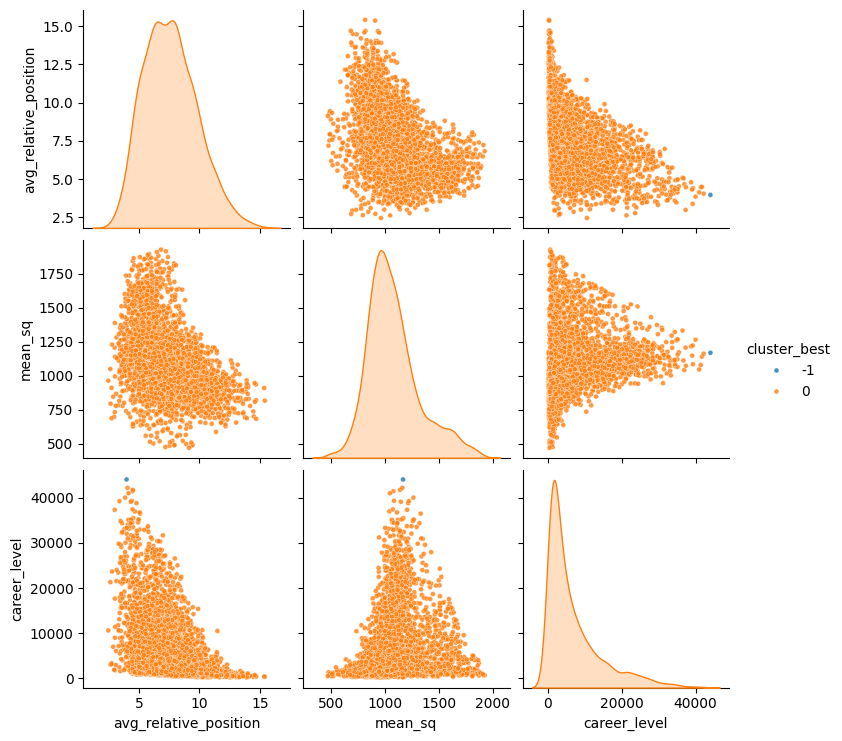

In [15]:
# Create a DataFrame with the scaled features and cluster labels
numerical_cyclists_df.loc[:, 'cluster_best'] = dbscan.labels_

# Plot pairplot with seaborn
sns.pairplot(numerical_cyclists_df, hue='cluster_best', plot_kws={'s': 13, 'alpha': 0.8}, palette="tab10")
plt.show()

This result is not so interesting given that this clustering found only one outlier and then a huge cluster with all data. Let's proceed finding a better result in terms of numbers of clusters found.
However, we do not expect very good results from this approach, as the data seems not to show dense and disconnected structures.

### Best Result With K>1
Let's try to find a better result with a number of clusters greater than 1.

In [16]:
results_df = pd.DataFrame(results)
positive_silhouette_df = results_df[results_df['silhouette'] > 0].sort_values(by=['n_clusters', 'silhouette'], ascending=[False, False])
positive_silhouette_df.head(20)

,eps,min_samples,n_clusters,silhouette,DBscore
80,0.049799,5,7,0.014906,1.778405
92,0.054774,10,6,0.137441,1.50115
84,0.049799,15,5,0.013620,3.037182
90,0.054774,5,4,0.223856,2.204169
91,0.054774,7,4,0.220808,2.098506
83,0.049799,12,4,0.000542,1.86761
146,0.079648,25,3,0.321200,1.57881
135,0.074673,20,3,0.310216,1.625994
113,0.064724,12,3,0.299019,1.545325
102,0.059749,10,3,0.298448,1.519215


Let's try some values of eps and min_samples

In [17]:
from sklearn.decomposition import PCA

eps = 0.064724
min_samples = 12

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(x_scaled)

DBSCAN(eps=0.064724, min_samples=12)

In [18]:
labels, counts = np.unique(dbscan.labels_, return_counts=True)
cluster_counts = dict(zip(labels, counts))
for label, count in cluster_counts.items():
    print(f"Cluster {label}: {count} samples")
    
numerical_cyclists_df.loc[:, 'cluster_best2'] = dbscan.labels_

Cluster -1: 139 samples
Cluster 0: 3304 samples
Cluster 1: 33 samples


/var/folders/hy/hstnjjns1znck26g7mhszl380000gn/T/ipykernel_51697/1630485433.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_cyclists_df.loc[:, 'cluster_best2'] = dbscan.labels_


Again, despite the number of cluster now is 2 (excluding the outliers), the result is not so good. Let's visualize it.

#### PCA

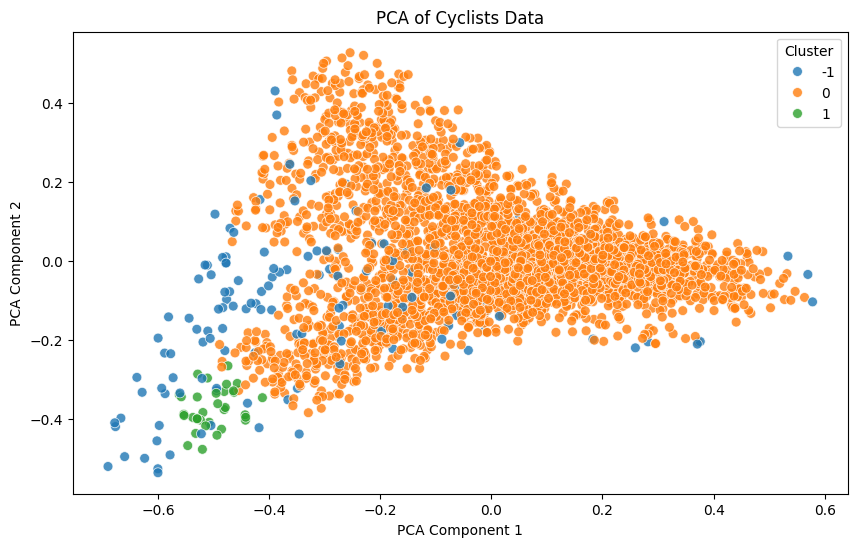

In [19]:
# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=x_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = dbscan.labels_

# Plot the PCA components with seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=50, alpha=0.8)
plt.title('PCA of Cyclists Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

#### Pairplot

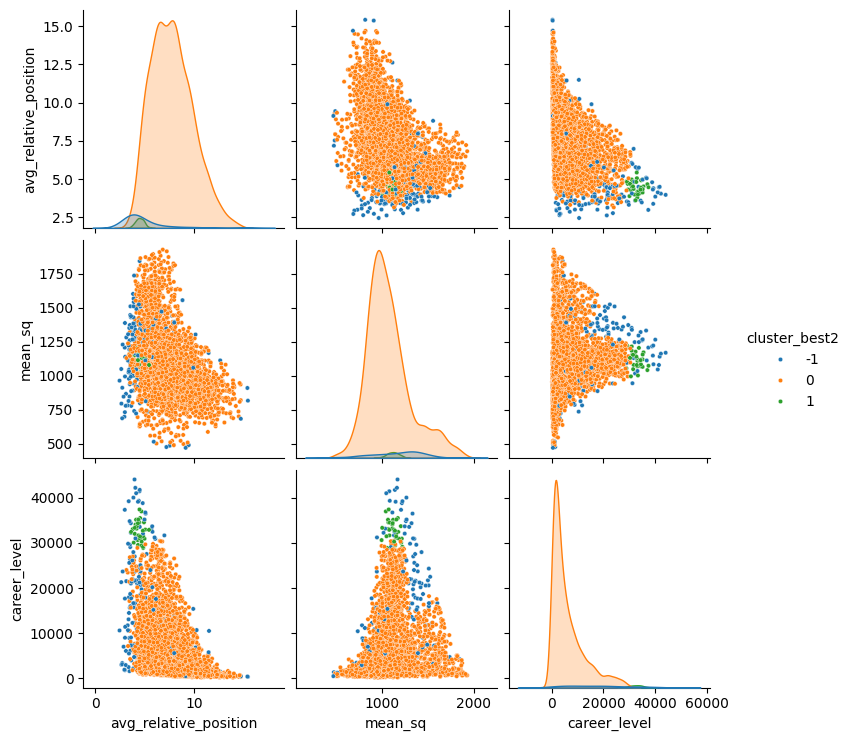

In [20]:
# Plot pairplot with seaborn
sns.pairplot(numerical_cyclists_df.drop(columns="cluster_best"), hue='cluster_best2', plot_kws={'s': 10, 'alpha': 1}, palette="tab10")
plt.show()

#### Similarity Plot

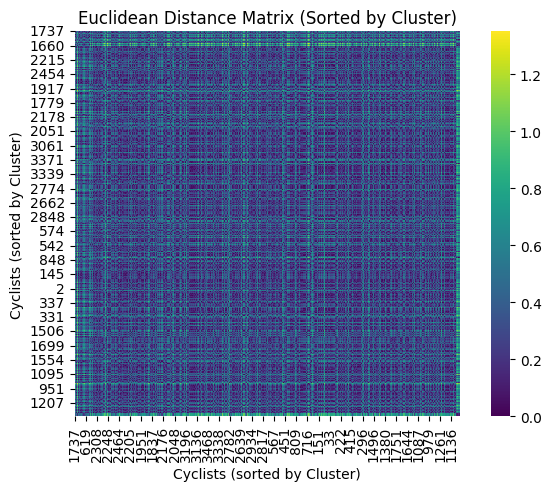

In [21]:
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# order the dataframe based on the cluster (from 0 = best to 2 = worst)
numeric_cyclists_df = pca_df.sort_values(by='cluster')

# normalize the features
scaler = StandardScaler()
features = numeric_cyclists_df.drop(columns=['cluster']).select_dtypes(include=[np.number])
features_normalized = scaler.fit_transform(features)

# calculate the euclidean distance matrix excluding the cluster
features = numeric_cyclists_df.drop(columns=['cluster']).select_dtypes(include=[np.number])
distance_matrix = euclidean_distances(features)

# order the distance matrix based on the cluster order
distance_matrix_sorted = pd.DataFrame(distance_matrix, index=numeric_cyclists_df.index, columns=numeric_cyclists_df.index)

# plot
plt.figure(figsize=(8, 5))
sns.heatmap(distance_matrix_sorted, cmap='viridis', square=True)
plt.title('Euclidean Distance Matrix (Sorted by Cluster)')
plt.xlabel('Cyclists (sorted by Cluster)')
plt.ylabel('Cyclists (sorted by Cluster)')
plt.show()


#### Statistics

Let's see hoe many cyclists are in each cluster (according to their career level).

First, just a 3D view of the clustering result

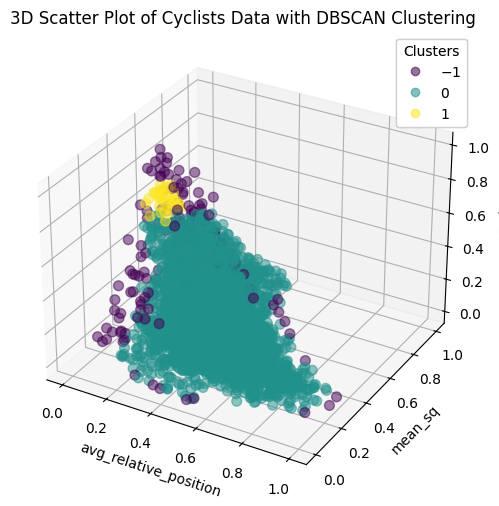

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with cluster labels
scatter = ax.scatter(x_scaled[:, 0], x_scaled[:, 1], x_scaled[:, 2], c=dbscan.labels_, cmap='viridis', s=50, alpha=0.5)

# Add labels and title
ax.set_xlabel(columns_to_keep[0])
ax.set_ylabel(columns_to_keep[1])
ax.set_zlabel(columns_to_keep[2])
ax.set_title('3D Scatter Plot of Cyclists Data with DBSCAN Clustering')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [23]:
numerical_cyclists_df.sort_values(by='career_level', ascending=False).head(60)['cluster_best2'].value_counts()

cluster_best2
 1    29
-1    28
 0     3
Name: count, dtype: int64

Considering a sample of 60 cyclists ordered by career level, it seems that the clustering tends to put the best ones in the cluster 1 (avoiding any outliers considerations).

Now we proceed in the attempt to characterize more the clusters.

In [24]:
cyclists_df['cluster_best2'] = numerical_cyclists_df['cluster_best2']

# filter the dataframe for each cluster value
best_cyclists_df = cyclists_df[cyclists_df['cluster_best2'] == 1]
rest_cyclists_df = cyclists_df[cyclists_df['cluster_best2'] == 0]
outlier_df = cyclists_df[cyclists_df['cluster_best2'] == -1]

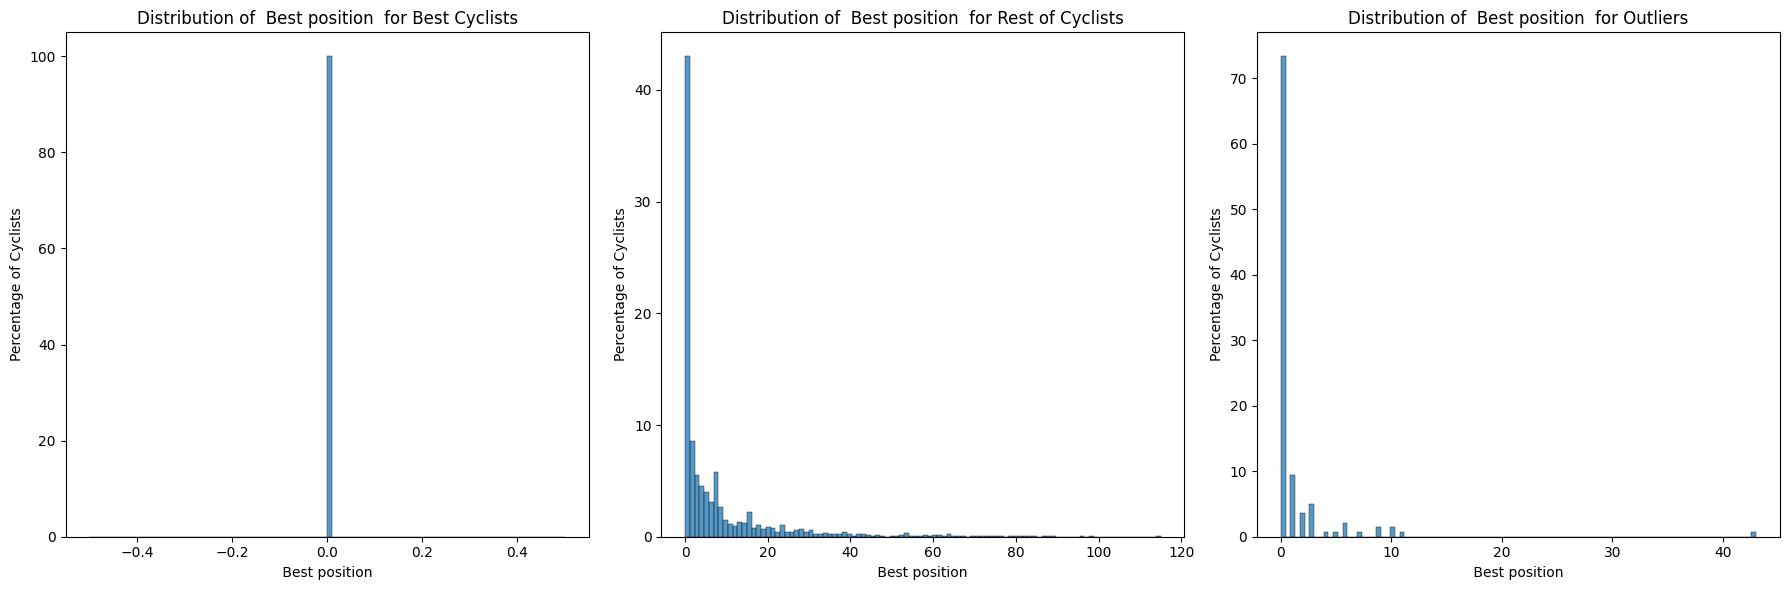

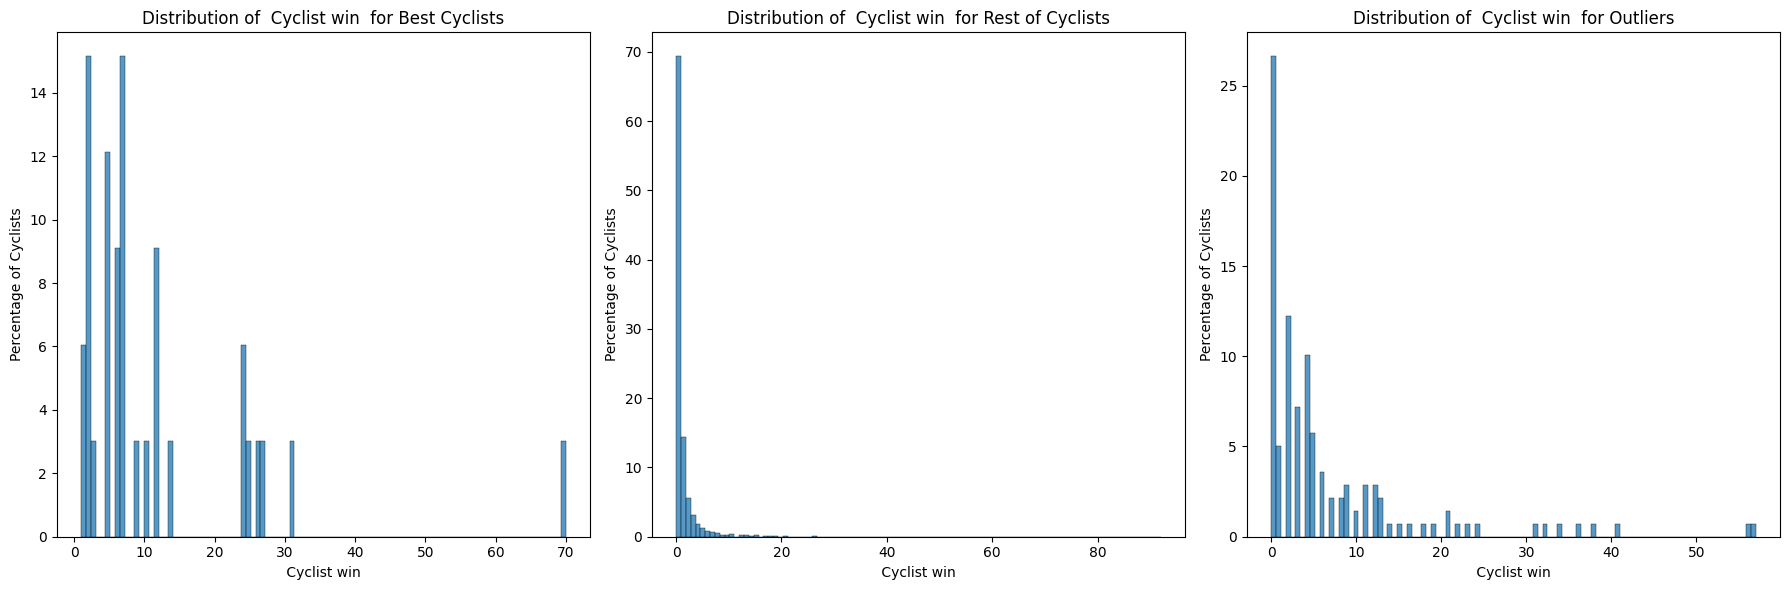

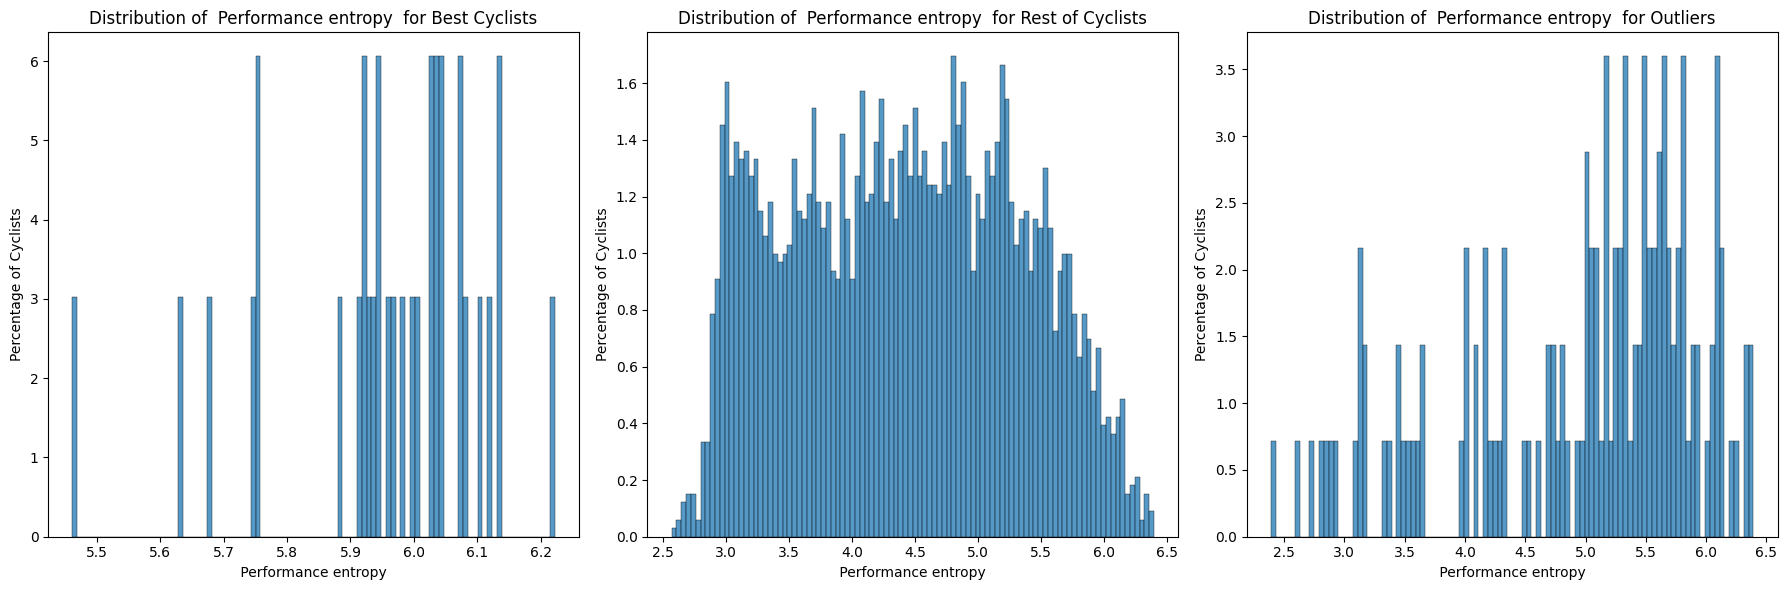

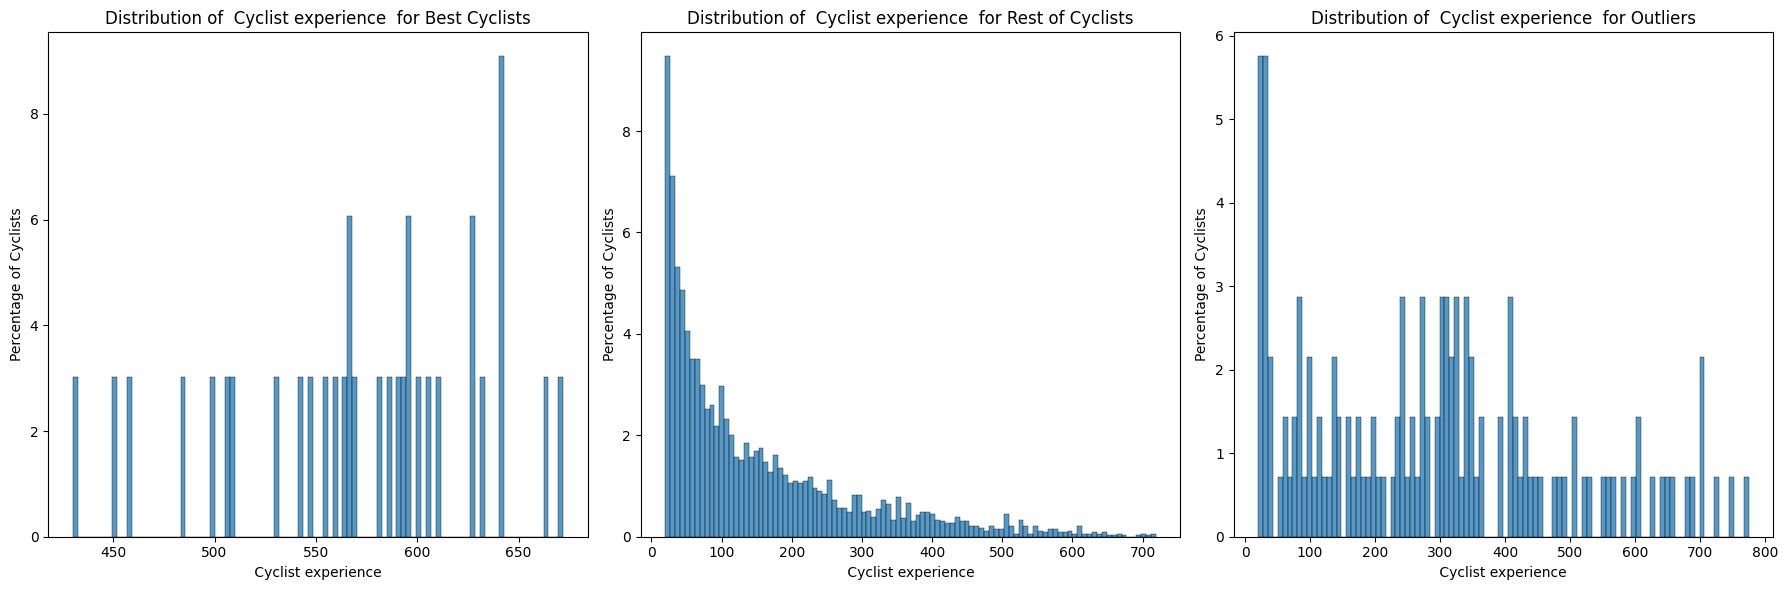

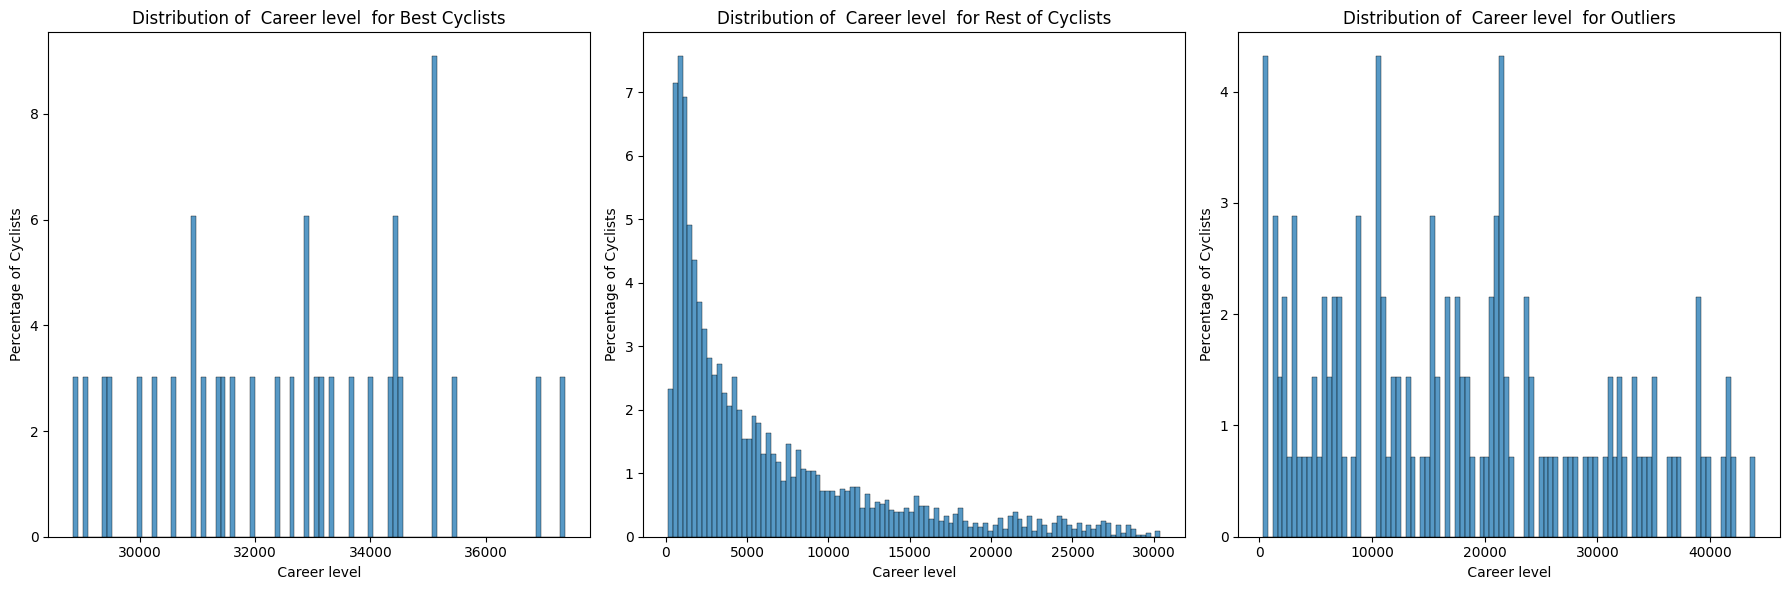

In [25]:
import sys
sys.path.append('..')

from utils import plot_parallel_cluster_distribution

plot_parallel_cluster_distribution(best_cyclists_df, rest_cyclists_df, outlier_df, 'best_position')
plot_parallel_cluster_distribution(best_cyclists_df, rest_cyclists_df, outlier_df, 'cyclist_win')
plot_parallel_cluster_distribution(best_cyclists_df, rest_cyclists_df, outlier_df, 'performance_entropy')
plot_parallel_cluster_distribution(best_cyclists_df, rest_cyclists_df, outlier_df, 'cyclist_experience')
plot_parallel_cluster_distribution(best_cyclists_df, rest_cyclists_df, outlier_df, 'career_level')


The plots that compare the distributions of three variables between the best cyclists and the rest shows that:

1. `best_position`: This plot shows that the best cyclists at least won one stage, while the most of the cyclists in the 0 cluster not. The outliers found by DBSCAN shows that the most of them won a stage (75%)

2. `cyclist_win`: The best cyclists have on average an higher number of wins. The plot reflects this by showing a greater frequency of higher win counts among the best cyclists compared to the rest. We can notice from outliers that a few points selected as outliers has higher number of wins, reflecting that probably some of the best cyclists are considered as outlier for their good performances.

3. `performance_entropy`: Best cyclists shows higher entropy in their performance. This could be an indicator of the fact that this cyclists has on average higher cyclist experience (so they partecipate to many many more stages wrt other cyclists), so their performances may fluctuate

3. `cyclist_experience`: in the Best Cyclist cluster it is reasonable to find cyclists with higher experience while the more cyclist with lower experience are "in the Rest". However, as happened for the other plot, the outliers plot shows overlapping results both clustering cyclists with high and low experience.

3. `career_level`: finally this plot shows that best cyclists falls in cluster 1 while some of them are in the tail of cluster 0 and many of them in the outlier cluster. Focusing on outlier cluster distribution is it possible to observe that also a lot of cyclists with very low experience and with very low career level are considered as outliers, probably because out of the distribution of the professional cyclists (cyclists with more stages participations, wins etc...)


#### Parallel Coordinates Plot

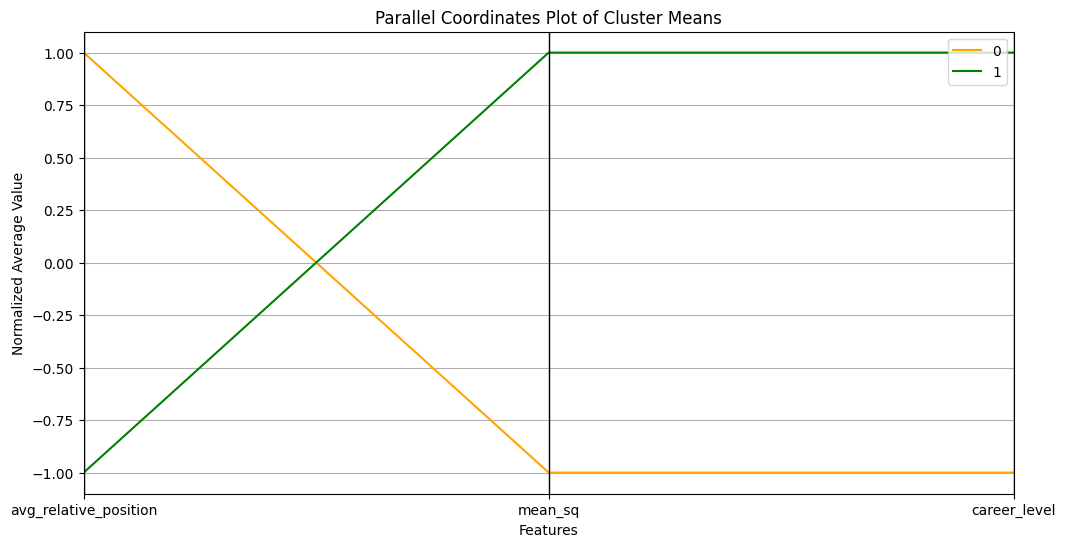

In [26]:
from pandas.plotting import parallel_coordinates

# Filter out the -1 cluster class
filtered_df = numerical_cyclists_df[numerical_cyclists_df['cluster_best2'] != -1]

# Calculate the average value of the three features in the different clusters
cluster_means = filtered_df.groupby('cluster_best2')[columns_to_keep].mean().reset_index()

cluster_means[columns_to_keep] = scaler.fit_transform(cluster_means[columns_to_keep])

# Plot parallel coordinates
plt.figure(figsize=(12, 6))
parallel_coordinates(cluster_means, 'cluster_best2', color=['orange', 'green'])
plt.title('Parallel Coordinates Plot of Cluster Means')
plt.xlabel('Features')
plt.ylabel('Normalized Average Value')
plt.show()

The green cluster (technically the cluster of the best ones) contains cyclists with higher `career_level` (stronger cyclists) and a with the lowest `average_relative_position`, so they on average place better wrt to other cyclists. Finally also `mean_sq` is higher for better cyclists, reflecting the fact that they partipate in stages with higher startlist quality on average, so more relevant ones. We have the opposit result for the orange one, that technically contains the worst cyclists.

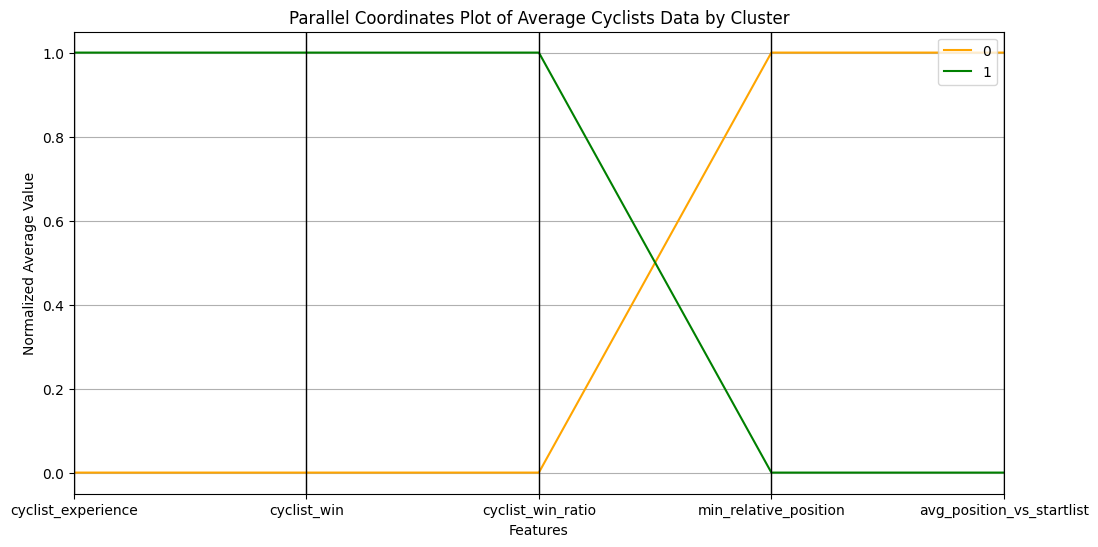

In [27]:
# Filter out the -1 cluster class
filtered_df = cyclists_df[cyclists_df['cluster_best2'] != -1]

columns_to_plot = ["cyclist_experience", "cyclist_win", "cyclist_win_ratio", "min_relative_position", "avg_position_vs_startlist"]

# Calculate the average value of the columns to plot in the different clusters
cluster_means = filtered_df.groupby('cluster_best2')[columns_to_plot].mean().reset_index()

# Define a new scaler
new_scaler = MinMaxScaler()

# Normalize the columns to plot
cluster_means[columns_to_plot] = new_scaler.fit_transform(cluster_means[columns_to_plot])

# Plot parallel coordinates
plt.figure(figsize=(12, 6))
parallel_coordinates(cluster_means, 'cluster_best2', color=['orange', 'green'])
plt.title('Parallel Coordinates Plot of Average Cyclists Data by Cluster')
plt.xlabel('Features')
plt.ylabel('Normalized Average Value')
plt.show()


In [28]:
from utils import compute_average_on_column

compute_average_on_column(cyclists_df, 'career_level', 'cluster_best2')
print("\n")
compute_average_on_column(cyclists_df, 'cyclist_experience', 'cluster_best2')
print("\n")
compute_average_on_column(cyclists_df, 'cyclist_win', 'cluster_best2')
print("\n")
compute_average_on_column(cyclists_df, 'cyclist_win_ratio', 'cluster_best2')
print("\n")
compute_average_on_column(cyclists_df, 'min_relative_position', 'cluster_best2')
print("\n")
compute_average_on_column(cyclists_df, 'avg_relative_position', 'cluster_best2')
print("\n")
compute_average_on_column(cyclists_df, 'performance_entropy', 'cluster_best2')


Average Value in column 'career_level' in cluster 0: 6145.442647917531
Average Value in column 'career_level' in cluster 1: 32665.096872755108


Average Value in column 'cyclist_experience' in cluster 0: 150.07899515738498
Average Value in column 'cyclist_experience' in cluster 1: 571.060606060606


Average Value in column 'cyclist_win' in cluster 0: 1.007869249394673
Average Value in column 'cyclist_win' in cluster 1: 11.636363636363637


Average Value in column 'cyclist_win_ratio' in cluster 0: 0.005528547751805021
Average Value in column 'cyclist_win_ratio' in cluster 1: 0.020997427267763085


Average Value in column 'min_relative_position' in cluster 0: 0.7537679968842602
Average Value in column 'min_relative_position' in cluster 1: 0.05632385371814408


Average Value in column 'avg_relative_position' in cluster 0: 7.724944406413731
Average Value in column 'avg_relative_position' in cluster 1: 4.479131871230765


Average Value in column 'performance_entropy' in cluster 0: 4.4033475

Cluster 1, representing the best cyclists, shows significantly higher career levels, greater experience, and more wins compared to Cluster 0. They also achieve much better relative positions, with higher variability in race outcomes. These cyclists demonstrate superior performance, an higher win ratio with an higher variability, due to their participations to more stages, highlighting their extensive racing background and accomplishments.